3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]
Rf [[-3.44509285e-16 -1.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  3.44509285e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]] end
[[1.87638837e+00 1.59287713e-15 0.00000000e+00]
 [1.59287713e-15 6.50000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.50000000e+00]] [0.  6.5 0. ] Here
[[1.87638837e+00 1.59287713e-15 0.00000000e+00]
 [1.59287713e-15 6.50000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.50000000e+00]] [0.  6.5 0. ]
globalpoly: 3
6
6


/usr/lib/python3/dist-packages/ipykernel_launcher.py:147: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:176: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:227: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


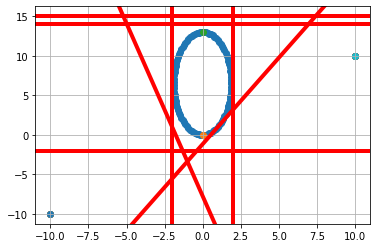

In [10]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np


import sys


bag = rosbag.Bag('simple.bag')
bbox = np.array([2,2,2])

def plotter(pi,p2,obs,out):

  plt.scatter(out[:,0],out[:,1])
  plt.scatter(p1[0],p1[1])
  plt.scatter(p2[0],p2[1])
  #plt.scatter(obs[:,0],obs[:,1])
  plt.grid()
def plotter_poly(globalpoly):
  for V in globalpoly:
    point = V[0]
    normal = V[1]
    d = point.dot(normal)
    plt.axline((point[0], point[1]), slope=-normal[0]/normal[1], linewidth=4, color='r')
    plt.scatter(10,10)
    plt.scatter(-10,-10)


def elp_sample(C,d,num):
  steps=np.linspace(0,2*np.pi,num)
  C = C[0:2,0:2]
  d = d[0:2]
  out = []
  for angle in steps:
    pt = [np.cos(angle),np.sin(angle)]
    pt= C.dot(pt)+d
    out.append(pt)
  out = np.asarray(out)
  return out

def dist_pt_ellipsoid_centre(pt,C,d):
  distance = np.linalg.norm(np.linalg.inv(C).dot(pt-d))
  return distance
def pt_is_inside_ep(pt,C,d):
    if dist_pt_ellipsoid_centre(pt,C,d)<=1:
      return True
    else:
      return False

def signed_dist_pt_plane(pt,V):
    n = V[1]
    p = V[0]
    distance = n.dot(pt-p)
    return distance
def dist_pt_plane(pt,V):
    abs_dist =  np.abs(signed_dist_pt_plane(pt,V))
    return abs_dist
def add_local_bbox(p1,p2,bbox):
    #P1 and P2 are 3*1 vectors
    #bbox is a l,b of the bbox around the line segment - 2D vector essentially
    
    #get unitvector parallel to the line segment:
    unitvec_parallel = (p2-p1)/np.linalg.norm(p2-p1)
    unitvec_norm = np.array([unitvec_parallel[1],-unitvec_parallel[0],0])
    unitvec_vert = np.array([0,0,0])
    unitvec_vert[0] = unitvec_parallel[1] * unitvec_norm[2] - unitvec_parallel[2] * unitvec_norm[1]
    unitvec_vert[1] = unitvec_parallel[2] * unitvec_norm[0] - unitvec_parallel[0] * unitvec_norm[2]
    unitvec_vert[2] = unitvec_parallel[0] * unitvec_norm[1] - unitvec_parallel[1] * unitvec_norm[0]
    hyperplanes = []
    #adding bbox planes parallel to line
    hyperplanes.append([p1+ unitvec_norm*bbox[1],unitvec_norm])
    hyperplanes.append([p1- unitvec_norm*bbox[1],-unitvec_norm])
    #adding bbox planes perpendicular to line
    hyperplanes.append([p2+ unitvec_parallel*bbox[0],unitvec_parallel])
    hyperplanes.append([p1- unitvec_parallel*bbox[0],-unitvec_parallel])   
    #adding bbox planes above and below the line
    hyperplanes.append([p1+unitvec_vert*bbox[2],unitvec_vert])
    hyperplanes.append([p1-unitvec_vert*bbox[2],-unitvec_vert])

    return hyperplanes

def pt_is_inside_poly(pt,Vs):
    check = True
    for V in Vs:
      if signed_dist_pt_plane(pt,V)>=0:
        check=False
    return check


def set_obs_Vs(obs,Vs):
    new_ob_set = []
    for pt in obs:
            if pt_is_inside_poly(pt,Vs):
                new_ob_set.append(pt)
    new_ob_set = np.array(new_ob_set)
    return new_ob_set  

def set_obs_ep(obs,C,d):
    new_ob_set = []
    for pt in obs:
            if pt_is_inside_ep(pt,C,d):
                new_ob_set.append(pt)
    new_ob_set = np.array(new_ob_set)
    return new_ob_set  

def vec_to_rotation(v):
  rpy = np.array([0,np.arctan2(-v[2],np.linalg.norm(v[0:1])),np.arctan2(v[1],v[0])]) #RPY of vector V
  rot = Rotation.from_euler('xyz', rpy, degrees=False)
  R = rot.as_matrix()
  return R

def closest_pt_ep(obs,C,d):
  min_dist = math.inf
  p = np.array([0,0,0])
  for pt in obs:
    if dist_pt_ellipsoid_centre(pt,C,d)<min_dist:
      min_dist = dist_pt_ellipsoid_centre(pt,C,d)
      p = pt
    
  return p



def find_ellipsoid(p1,p2,offset_x,obs,inflate_distance):
  eps_limit = 0.00001
  d = (p1+p2)/2
  C =  np.linalg.norm(p1-p2)/2 * np.identity(3)  
  C[0,0] +=   offset_x
  axes = np.linalg.norm(p1-p2)/2+np.array([offset_x,0,0])
  if axes[0]>0:
    C = C*(axes[1]/axes[2])
    axes = axes*(axes[1]/axes[2])
  R = vec_to_rotation(p2 - p1)
  C = R.dot(C.dot(R.transpose()))
  d = (p1+p2)/2
  Rf = R
  obs_inflated = []
  obs_preserve = obs

  for pt in obs:
    p = R.transpose().dot(pt-d)
    obs_check = R.dot(np.array([p[0]-np.sign(p[0]) * inflate_distance,p[1]-np.sign(p[1]) * inflate_distance,p[2]-np.sign(p[2]) * inflate_distance]))+d
    if pt_is_inside_ep(obs_check,C,d):
      obs_inflated.append(obs_check)
  obs = np.asarray(obs_inflated)
  obs_inside = obs
  while (obs_inside!=[]):
    pw = closest_pt_ep(obs_inside,C,d)
    p=R.transpose().dot(pw-d)
    roll = np.arctan2(p[2],p[1])
    quat_roll = Rotation.from_quat([np.cos(roll/2),np.sin(roll/2),0,0])
    Rf = R.dot(quat_roll.as_matrix())
    print("Rf",Rf,"end")
    p = Rf.transpose().dot(pw-d)
    if (p[0]<axes[0]):
      axes[1] = np.abs(p[1]/np.sqrt(1-(p[0]/axes[0])**2))
    new_C = np.identity(3)
    new_C[0,0]=axes[0]
    new_C[1,1]=axes[1]
    new_C[2,2]=axes[1]
    C = Rf.dot(new_C.dot(Rf.transpose()))
    obs_retain = []
    for pt in obs_inside:
      if (1-dist_pt_ellipsoid_centre(pt,C,d)>eps_limit):
        obs_retain.append(pt)
    obs_inside = obs_retain
  #Done with loop

  C = np.identity(3)
  C[0,0] = axes[0]
  C[1,1] = axes[1]
  C[2,2] = axes[2]
  C = Rf.dot(C.dot(Rf.transpose()))
  obs_inside = set_obs_ep(obs,C,d)
  print(C,d,"Here")
  while (obs_inside !=[]):
    pw = closest_pt_ep(obs_inside,C,d)
    p=Rf.transpose().dot(pw-d)
    if (1-(p[0]/axes[0])**2 - (p[1]/axes[1])**2 > eps_limit):
      axes[2] = np.abs(p[2]/np.sqrt(1-(p[0]/axes[0])**2 - (p[1]/axes[1])**2))
    new_C = np.identity(3)
    new_C[0,0]=axes[0]
    new_C[1,1]=axes[1]
    new_C[2,2]=axes[2]
    C = Rf.dot(new_C.dot(Rf.transpose()))
    obs_retain = []
    for pt in obs_inside:
      if (1-dist_pt_ellipsoid_centre(pt,C,d)>eps_limit):
        obs_retain.append(pt)
    obs_inside = obs_retain
  return C,d

def nearest_hyperplane(C,d,obs):
  pw = closest_pt_ep(obs,C,d)
  Cinv = np.linalg.inv(C)
  n = Cinv.dot(Cinv.transpose().dot(pw-d))
  norm_n = np.linalg.norm(n)
  if norm_n ==0:
    n_normalized = n
  else:
    n_normalized = n/norm_n
  closest_hp = [pw,n_normalized]
  return closest_hp


print(sys.version)
#p1 = np.array([5,11.5,0.5])
#p2 = np.array([13,11.5,3.0])
p1 = np.array([0,0,0])
p2 = np.array([0,13,0])
obs = np.array([[1,1,0],[2,2,0],[-2,1,0],[5,5,0],[0,14,0]])

offset_x = 0
drone_radius = 0

bbox = [2,2,1]

init_hyperplanes = add_local_bbox(p1,p2,bbox)

obs_init = obs
obs = set_obs_Vs(obs,init_hyperplanes)
C,d = find_ellipsoid(p1,p2,offset_x,obs,drone_radius)
print(C,d)

obs_remain = obs_init
globalpoly = []
while(obs_remain!=[]):
  hypplane = nearest_hyperplane(C,d,obs_remain)
  if not hypplane[1].all():
    globalpoly.append(hypplane)
  obs_retain = []
  for pt in obs_remain:
    if pt_is_inside_poly(pt,globalpoly):
        obs_retain.append(pt)
  obs_remain = obs_retain

#def calculate_min_poly_vertices

print("globalpoly:",len(globalpoly))
print(len(init_hyperplanes))
globalpoly = globalpoly+init_hyperplanes
print(len(init_hyperplanes))
plotter(p1,p2,obs_init,elp_sample (C,d,100))###PLOTTER
plotter_poly(globalpoly)

  


